In [1]:
import numpy as np
import pandas as pd

feat = np.load("/content/drive/My Drive/Colab Notebooks/Cópia de feat.npy", allow_pickle = True)
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Cópia de train.csv")[0:94823]
path = np.load("/content/drive/My Drive/Colab Notebooks/Cópia de path.npy")
test= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cópia de test.csv')

In [104]:
# Index features to the corresponding words on the train file

data = pd.DataFrame({'path':path, 'features':feat})
combined =pd.merge(train,data, on="path")


In [105]:
combined.head(5)

,path,word,features
0,8d37d10e7f97ddea2eca9d39a4cf821b4457b041.wav,one,"[[-10.160675, -13.804866, 0.9188097, 4.415375,..."
1,9a8f761be3fa0d0a963f5612ba73e68cc0ad11ba.wav,one,"[[-10.482644, -13.339122, -3.4994812, -5.29343..."
2,314cdc39f628bc68d216498b2080bcc7a549a45f.wav,one,"[[-11.076196, -13.980294, -17.289637, -41.0668..."
3,cc499e63eee4a3bcca48b5b452df04990df83570.wav,one,"[[-13.830213, -12.64104, -3.7780707, -10.76490..."
4,38cdcc4d9432ce4a2fe63e0998dbca91e64b954a.wav,one,"[[-11.967776, -23.27864, -10.3656, -8.786977, ..."


In [106]:
combined["features"][0].shape

(99, 13)

In [107]:
# padding feature to the same length

pad_feat = []

for i in combined["features"]:
    if i.shape != (99,13):
        rows = 99 - i.shape[0]
        columns = 13 - i.shape[1]
        pad_feat.append(np.pad(i, ((0, rows), (0, columns)), 'constant', constant_values = 0))
    else:
        pad_feat.append(i)
    
features = np.array(pad_feat)

In [108]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = features
y = combined['word']

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

In [110]:
# check if labels and features have the same length

len(y) == len(X)

True

In [111]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.15, random_state = 42)

In [112]:
x_train.shape

(80599, 99, 13)

In [113]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 99
num_columns = 13
num_channels = 1

#Reshape to the correct number of dimensions
x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

In [128]:
# Construct model 
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5), input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [129]:
# Display model architecture summary 
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 95, 9, 64)         1664      
_________________________________________________________________
dropout_24 (Dropout)         (None, 95, 9, 64)         0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 93, 7, 256)        147712    
_________________________________________________________________
dropout_25 (Dropout)         (None, 93, 7, 256)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 91, 5, 256)        590080    
_________________________________________________________________
dropout_26 (Dropout)         (None, 91, 5, 256)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 89, 3, 512)      

In [130]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

445/445 [==============================] - 3s 6ms/step - loss: 3.5942 - accuracy: 0.0395
Pre-training accuracy: 3.9511%


In [131]:
#Train the model

from datetime import datetime 

num_epochs = 20
num_batch_size = 128

start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test),  verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/20
630/630 [==============================] - 39s 63ms/step - loss: 2.2145 - accuracy: 0.3798 - val_loss: 1.1889 - val_accuracy: 0.6696
Epoch 2/20
630/630 [==============================] - 39s 62ms/step - loss: 0.9679 - accuracy: 0.7276 - val_loss: 0.7025 - val_accuracy: 0.8028
Epoch 3/20
630/630 [==============================] - 39s 62ms/step - loss: 0.6781 - accuracy: 0.8076 - val_loss: 0.5390 - val_accuracy: 0.8467
Epoch 4/20
630/630 [==============================] - 39s 62ms/step - loss: 0.5641 - accuracy: 0.8366 - val_loss: 0.4894 - val_accuracy: 0.8631
Epoch 5/20
630/630 [==============================] - 39s 62ms/step - loss: 0.4933 - accuracy: 0.8569 - val_loss: 0.4397 - val_accuracy: 0.8749
Epoch 6/20
630/630 [==============================] - 39s 62ms/step - loss: 0.4477 - accuracy: 0.8692 - val_loss: 0.3940 - val_accuracy: 0.8861
Epoch 7/20
630/630 [==============================] - 39s 62ms/step - loss: 0.4115 - accuracy: 0.8806 - val_loss: 0.3661 - val_accuracy:

In [95]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


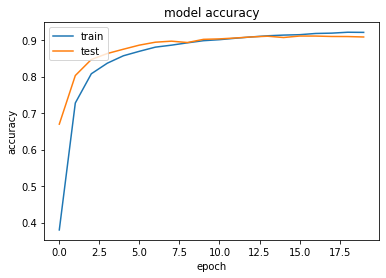

In [132]:
#Plotting accuracy during training

import matplotlib.pyplot as plt
plt.plot(model.history.history["accuracy"])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [133]:
# Evaluate the model on the training and validation set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9584113955497742
Testing Accuracy:  0.9083942770957947


In [134]:
Test_data =pd.merge(test,data, on="path")

In [135]:
pad_feat = []

for i in Test_data["features"]:
    if i.shape != (99,13):
        rows = 99 - i.shape[0]
        columns = 13 - i.shape[1]
        pad_feat.append(np.pad(i, ((0, rows), (0, columns)), 'constant', constant_values = 0))
    else:
        pad_feat.append(i)
    
test_data = np.array(pad_feat)

In [136]:
# Do the predictions for the test data

test_data=test_data.reshape(test_data.shape[0], num_rows, num_columns, num_channels)

predictions=model.predict(test_data)
predictions=np.argmax(predictions,axis=1)
predictions=le.inverse_transform(predictions)

In [ ]:
# Save the predictions in the appropriate format

np.savetxt('/content/drive/My Drive/ML/predictions.csv',predictions, fmt='%s')
word = pd.read_csv("/content/drive/My Drive/ML/predictions.csv", header = None)
test['word'] = word
pd.DataFrame.to_csv(test, '/content/drive/My Drive/ML/result.csv', index = False)